In [1]:
# NOTES FROM MEETING
# No cell should take more than 20 minutes to run
# Please limit to one temporary collection (must be deleted at end of notebook). No external files
# Try to reduce single-line cells

# Mini-competition -
# Challenge: Limit to 75 lines of code (100 for team 1)! (excluding imports)
# Fit Success Rate: Fitting method with highest fit success rate
# Fit Average error: Fitting method with lowest fit error rate
# Fit Time complexity: Fitting method with lowest time expended
# Notebook housekeeping: Cleanest-looking notebook win!

# Sigmoid Criteria Curve Fitting: CDF Approach
**Contributors:** Karen Nguyen, Sophie Yun, Emily Gong

**Achievement:** 

**Requirements:**


## Import packages 
**This is a note:** Please have markdown before each cell. In this format!

In [31]:
import sys
sys.path.append('../..')
from pymongo import UpdateOne
from pymongo import MongoClient
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm 
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.stats import t
from mlpp.data_modeling.sigmoid_fitting import *
import pandas as pd

## Instantiate mongo instance, classes, and any config/global vars

In [42]:
client = MongoClient(port=27017)
db = client.osu_random_db
bm_ids = list(map(lambda c: c['_id'], db['beatmap_criteria_curve'].find({}, {})))

## Load the curve data
**Note:** Get total and n_pass under no_mod for all beatmaps

In [43]:
bm_data = {}
for i in bm_ids:
    bm_data[i] = list(db['beatmap_criteria_curve'].find({"_id": i}, {"_id": 0, "no_mod.total": 1, "no_mod.n_pass": 1}))

**Note:** Calculate the n_pass/total for each user with total = 0 removed

In [44]:
def find_nPassOverTotal_for_one_beatmap (bm):
    bm_total_nPass = list (zip (bm_data[bm][0]["no_mod"]["total"], bm_data[bm][0]["no_mod"]["n_pass"]))
    bm_total_nPass_noZero = [total_nPass for total_nPass in bm_total_nPass if total_nPass[0] != 0]
    y = np.asarray(list(zip(*bm_total_nPass_noZero))[1]) / np.asarray(list(zip(*bm_total_nPass_noZero))[0])
    return y
bm_ys = {}
for i in bm_ids:
    bm_ys[i] = find_nPassOverTotal_for_one_beatmap (i)

## Run all Normal CDF curve fits and store in a collection

In [45]:
fitted_curves_with_errors = {}

for i in bm_ys.keys():
    fitted_curves_with_errors[i] = fit_normal_cdf(bm_ys[i])

[Text(0, 0.5, 'nPass/total')]

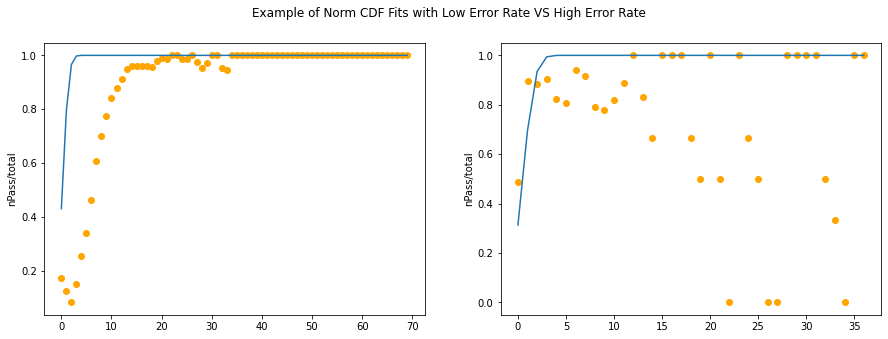

In [46]:
# visualization example beatmaps
good = 713935
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Example of Norm CDF Fits with Low Error Rate VS High Error Rate')
x1 = range(len(find_nPassOverTotal_for_one_beatmap(good)))
y1 = find_nPassOverTotal_for_one_beatmap(good)
ax1.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(good)[0]).cdf(x1))
ax1.scatter(x1, y1, color = "orange")
ax1.set(ylabel = "nPass/total")

bad = 848233
x2 = range(len(find_nPassOverTotal_for_one_beatmap(bad)))
y2 = find_nPassOverTotal_for_one_beatmap(bad)
ax2.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(bad)[0]).cdf(x2))
ax2.scatter(x2, y2, color = "orange")
ax2.set(ylabel = "nPass/total")

In [68]:
unsuccessful_bm = {id: fitAndMse for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse, str)}
n = len(fitted_curves_with_errors)
success_rate = (n - len(unsuccessful_bm))/n
avg_mse = np.mean([fitAndMse[1] for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse[1], float)])
print("success rate for all is:", success_rate)
print("average mse for all is:", avg_mse)

success rate for all is: 0.9996666666666667
average mse for all is: 0.03714103365330562


In [57]:
for el in bm_ids: 
    success = False if el in unsuccessful_bm.keys() else True
    mean = None if el in unsuccessful_bm.keys() else fitted_curves_with_errors[el][0][0]
    sd = None if el in unsuccessful_bm.keys() else fitted_curves_with_errors[el][0][1]
    mse = None if el in unsuccessful_bm.keys() else fitted_curves_with_errors[el][1]
    
    db.beatmap_criteria_curve.update_one( 
        {"_id" : el},
        {"$set": {"no_mod.mlpp.normalCDF.success" : success,
                  "no_mod.mlpp.normalCDF.params.mean" : mean,
                  "no_mod.mlpp.normalCDF.params.sd" : sd,
                  "no_mod.mlpp.normalCDF.mse" : mse}}
    )

## Load the beatmap attribs data

In [48]:
bm_attribs_data = {}
for i in bm_ids:
    bm_attribs_data[i] = list(db['osu_beatmap_attribs'].find({"beatmap_id": i, "mods": 0, "attrib_id":17}, {"_id": 0, "value": 1}))

## Dataframe of Correlation between CDF mean/std with attribs
**Note:** Each beatmap maps the same mean, sd, mse mapped to its different attrib_ids

In [50]:
# creating a dataframe with rows as bm_ids and columns as mean, std, mse, and star difficulties
attrib_array = []
mean_array = []
sd_array = []
mse_array = []
successful_ids = [bm for bm in bm_ids if bm not in unsuccessful_bm.keys()]
for bm in successful_ids:
    attrib_array.append(bm_attribs_data[bm][0]["value"])
    mean_array.append(fitted_curves_with_errors[bm][0][0]) 
    sd_array.append(fitted_curves_with_errors[bm][0][1]) 
    mse_array.append(fitted_curves_with_errors[bm][1])

In [52]:
new_df = pd.DataFrame(successful_ids)
new_df["star"] = np.array(attrib_array)
new_df["mean"] = np.array(mean_array)
new_df["sd"] = np.array(sd_array)
new_df["mse"] = np.array(mse_array)
new_df.columns = ["Successful_ids", "Star_difficulties", "Mean", "Sd", "MSE"]
new_df

,Successful_ids,Star_difficulties,Mean,Sd,MSE
0,315550,1.71815,0.019015,0.608820,0.136021
1,453359,1.75883,0.179988,0.661276,0.047169
2,315553,1.98731,0.191851,0.646722,0.019471
3,1036654,1.62921,-0.021693,0.544115,0.012222
4,351190,1.84494,-0.016056,0.550648,0.045571
...,...,...,...,...,...
2994,1607651,3.15494,2.805553,3.432014,0.074937
2995,355283,3.18799,4.361921,5.235403,0.002739
2996,133612,1.44691,-23.762525,31.595397,0.041346
2997,681786,4.38915,7.687208,5.267253,0.029396


## Summary Table of Success Rate and MSE for Normal CDF Curve Fit

In [69]:
unsuccessful_attrib_data = bm_attribs_data[list(unsuccessful_bm.keys())[0]]
unsuccessful_attrib_array = [id_dict["value"] for id_dict in unsuccessful_attrib_data]

unsuccessful_attrib_low = [a for a in unsuccessful_attrib_array if a >= 1 and a < 4]
unsuccessful_attrib_med = [a for a in unsuccessful_attrib_array if a >= 4 and a < 6]
unsuccessful_attrib_high = [a for a in unsuccessful_attrib_array if a >= 6]

successful_attrib_low = [a for a in attrib_array if a >= 1 and a < 4]
successful_attrib_med = [a for a in attrib_array if a >= 4 and a < 6]
successful_attrib_high = [a for a in attrib_array if a >= 6]

In [71]:
attrib_and_mse = list(zip(attrib_array, mse_array))
error_low_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] >= 1 and aAndM[0] < 4]
error_med_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] >= 4 and aAndM[0] < 6]
error_high_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] >= 6]
success_error_summary = {
    "1-4": [len(successful_attrib_low) / (len(unsuccessful_attrib_low) + len(successful_attrib_low)), np.mean(error_low_array)],
    "4-6": [len(successful_attrib_med) / (len(unsuccessful_attrib_med) + len(successful_attrib_med)), np.mean(error_med_array)],
    "6+": [len(successful_attrib_high) / (len(unsuccessful_attrib_high) + len(successful_attrib_high)), np.mean(error_high_array)],
    "All": [len(attrib_array) / (len(unsuccessful_attrib_array) + len(attrib_array)), np.mean(mse_array)]
}
success_error_summary_df = pd.DataFrame(success_error_summary)
success_error_summary_df.index = ["Success_rate", "Error_rate"]

In [72]:
success_error_summary_df

,1-4,4-6,6+,All
Success_rate,1.000000,1.000000,0.989362,0.999667
Error_rate,0.053021,0.011779,0.018162,0.037141


## Run all T CDF curve fits and store in a collection

In [73]:
fitted_tcdf_with_errors = {}

for i in bm_ys.keys():
    fitted_tcdf_with_errors[i] = fit_t_cdf(bm_ys[i])

In [65]:
unsuccessful_bm = {id: fitAndMse for (id, fitAndMse) in fitted_tcdf_with_errors.items() if isinstance(fitAndMse, str)}
n = len(fitted_curves_with_errors)
success_rate = (n - len(unsuccessful_bm))/n
avg_mse = np.mean([fitAndMse[1][0] for (id, fitAndMse) in fitted_tcdf_with_errors.items() if isinstance(fitAndMse[1][0], float)])
print("success rate for all is:", success_rate)
print("average mse for all is:", avg_mse)

success rate for all is: 1.0
average mse for all is: 0.06375869798417359


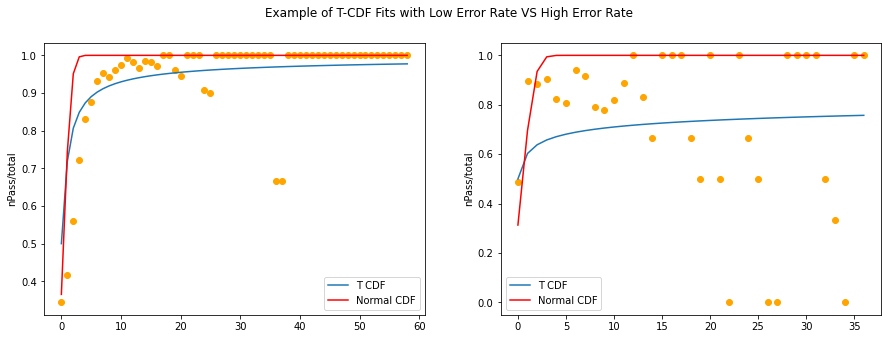

In [61]:
good = 1262009
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Example of T-CDF Fits with Low Error Rate VS High Error Rate')
x1 = range(len(find_nPassOverTotal_for_one_beatmap(good)))
y1 = find_nPassOverTotal_for_one_beatmap(good)
df1,mse1 = fit_t_cdf(y1)
ax1.plot(scipy.stats.t(df1).cdf(x1), label = "T CDF")
ax1.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(good)[0]).cdf(x1), color = "red", label = "Normal CDF")
ax1.scatter(x1, y1, color = "orange")
ax1.set(ylabel = "nPass/total")
leg1 = ax1.legend();

bad = 848233
x2 = range(len(find_nPassOverTotal_for_one_beatmap(bad)))
y2 = find_nPassOverTotal_for_one_beatmap(bad)
df2,mse2 = fit_t_cdf(y2)
ax2.plot(scipy.stats.t(df2).cdf(x2), label = "T CDF")
ax2.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(bad)[0]).cdf(x2), color =  "red", label = "Normal CDF")
ax2.scatter(x2, y2, color = "orange")
ax2.set(ylabel = "nPass/total")
leg2 = ax2.legend()

In [66]:
for el in bm_ids: 
    success = False if el in unsuccessful_bm.keys() else True
    df = None if el in unsuccessful_bm.keys() else fitted_tcdf_with_errors[el][0][0]
    mse = None if el in unsuccessful_bm.keys() else fitted_tcdf_with_errors[el][1][0]
    
    db.beatmap_criteria_curve.update_one( 
        {"_id" : el},
        {"$set": {"no_mod.mlpp.tCDF.success" : success,
                  "no_mod.mlpp.tCDF.params.df" : df,
                  "no_mod.mlpp.tCDF.mse" : mse}}
    )